# Retrieving a given component of a Matrix Product State

In this tutorial we will set up a basic Matrix Product state with the use of the _TensorNetwork_ library and we will apply a very basic algorithm: retreving a selected component from the structure.

In [0]:
# run with python3
# written by Sebastian Grijalva
# (Please send feedback!)
# sebastian.grijalva@protonmail.com
# thanks to Martin Ganahl: github.com/mganahl

!pip install tensornetwork 

from sys import getsizeof
import gc

import tensornetwork as tn
import numpy as np
import matplotlib.pyplot as plt

We begin by observing the scaling of the cost of storing larger and larger tensors and retrieving a component, as the dimension increases. While the computational complexity of accessing an item in a multidimensional array is $O(1)$, the main cost is the exponentially growing *memory* required to store the tensor.

Let our tensor be $T^{s_1 \cdots s_{\textsf{Rank}}}$ (the _Rank_ for the tensor is usually thought of as the _system size_), where each $s_i \in \{1, \ldots d_i\}$ and where $d_i$ is called a _physical dimension_. For example, in physical applications, $d_i = 2 \hspace{5pt} \forall i$, and each $s_i$ is called a *qubit*.


Now let's create a tensor with random entries, with ranks and physical dimensions that run over small ranges:

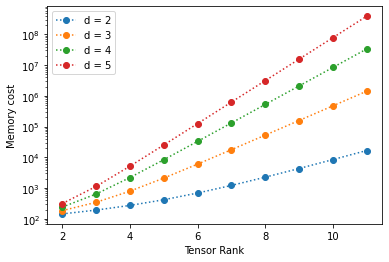

In [0]:
def create_tensor(dimension, rank):
    '''Constructs a tensor of a given rank with random integers'''
    dim_list = tuple([dimension for _ in range(rank)])
    return np.random.random_sample(dim_list)

ranks = range(2,12)
dimensions = range(2,6) 

for dim in dimensions:
    memory = []
    for rank in ranks:
        tensor = create_tensor(dim, rank)
        component = tuple(np.random.randint(0, dim, rank))
        memory.append(getsizeof(tensor))
        data = tensor[component]
    plt.semilogy(ranks, memory,'o',ls=':', label = f'd = {dim}')

plt.legend()
plt.xlabel('Tensor Rank')
plt.ylabel('Memory cost')
plt.show()

We see that the memory required to store this array scales as $\sim d^{\textsf{Rank}}$. This is an exponential growth, which quickly saturates our computational resources. One way to work around this "dimensionality catastrophe" is to focus on a particular kind of tensors: Those that can be written as a *Matrix Product State*:

$$
T^{s_1 \ldots s_\textsf{Rank}} = \sum_{\{\alpha\}} A^{s_1}_{\alpha_1}A^{s_2}_{\alpha_1 \alpha_2}A^{s_3}_{\alpha_2 \alpha_3}  \cdots A^{s_\textsf{Rank-1}}_{\alpha_{\textsf{Rank}-2}\alpha_{\textsf{Rank} - 1}}A^{s_\textsf{Rank}}_{\alpha_{\textsf{Rank}-1}}
$$

where $\{ \alpha \} = \{ \alpha_1, \ldots, \alpha_{\textsf{Rank}-1}\}$, and $\alpha_i \in \{1 \cdots D_i \}$.

As an important case, any quantum many-body state can be written as a MPS by using the _Schmidt Decomposition Theorem_ . In this tutorial we will take all $D_i$ (also called _bond dimension_) equal to a single $D$ .

#Building the MPS

We begin by creating directly the node structure of the MPS. First we define functions to build each block of the MPS and then the MPS itself:

In [0]:
##Retrieving a component

def block(*dimensions):
    '''Construct a new matrix for the MPS with random numbers from 0 to 1'''
    size = tuple([x for x in dimensions])
    return np.random.random_sample(size)

def create_MPS(rank, dimension, bond_dimension):
    '''Build the MPS tensor'''
    mps = [tn.Node( block(dim, bond_dim) )] + [tn.Node( block(bond_dim, dim, bond_dim)) for _ in range(rank-2)] + [tn.Node( block(bond_dim, dim) )]

    #connect edges to build mps
    connected_edges=[]
    conn=mps[0][1]^mps[1][0]
    for k in range(1,rank-1):
        conn=mps[k][2]^mps[k+1][0]
        connected_edges.append(conn)

    return mps, connected_edges

We will calculate the memory size of MPS of different dimensions and ranks (notice we are able to go much farther than before)

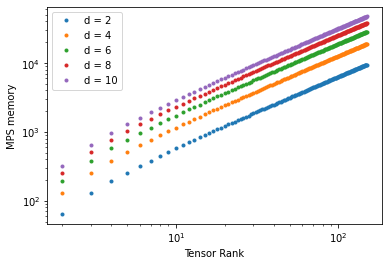

In [0]:
dimensions = range(2,11,2)
MPS_ranks = range(2,150)
MPS_memory = []

for dim in dimensions:
    bond_dim = 2
    MPS_memory = []
    for i in range(len(MPS_ranks)):
        rank = MPS_ranks[i]

        # Creating the MPS state:
        ###############################################################################
        mps_nodes, mps_edges = create_MPS(rank, dim, bond_dim)
        nbytes = 0
        for node in mps_nodes:
            nbytes += node.tensor.nbytes #works only for numpy

        MPS_memory.append(nbytes)

    # Plot Results
    plt.loglog(MPS_ranks, MPS_memory, '.', label = f'd = {dim}')

plt.legend()
plt.xlabel('Tensor Rank')
plt.ylabel('MPS memory')

plt.show()

We see that memory requirements drop significantly: the scaling is now $~\textsf{Rank}^{\textsf{const.}}$(which is polynomial). We can probe higher physical dimensions with less memory. 


Now we retrieve a component of, say a 2d physical dimension system of rank 24. This is equivalent to accessing the components of some wavefunction of a 1D quantum chain of 24 qubits! The main computational cost will be the contraction of the MPS bonds. Here we use a simple algorithm to perform the calculation: contract each bond successively until the entire MPS has collapsed to the desired component of the tensor.

With this scheme, the Google Colab sheet can process up to 28 qubits.

In [0]:
########################################################################
#----- Retrieving a Component from an MPS by Contracting its edges-----#
########################################################################
dim = 2
bond_dim = 2
rank = 24
components=tuple(np.random.randint(0, dim, rank)) #select randomly the components that we will retrieve
print(f'components are: {components}')

mps_nodes, mps_edges = create_MPS(rank, dim, bond_dim)
for k in range(len(mps_edges)):
    A = tn.contract(mps_edges[k])

#the last node now has all the edges corresponding to the tensor components. 

A.tensor[components]

components are: (0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0)


0.14500532524136947

#Using the TensorNetworks library


Now let's use the optimized built-in class from TensorNetworks. First we define a function that gives the byte cost of a given node in our tensor network:


In [0]:
def get_mps_size(mps):
    assert mps.backend.name=='numpy'
    nbytes = 0
    for node in mps.nodes:
        nbytes += node.tensor.nbytes # works only for numpy
    return nbytes

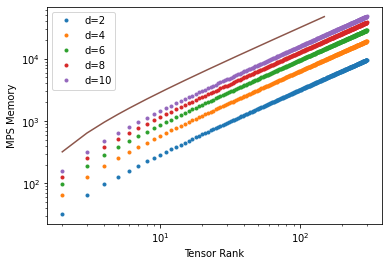

In [0]:
from tensornetwork import matrixproductstates as mps

dimensions = range(2,11,2)
ranks = range(2,300)
    
bond_dim = 2 # constant
for phys_dim in dimensions:
    memory = []
    for rank in ranks:    
        mps = tn.FiniteMPS.random(d = [phys_dim for _ in range(rank)], D = [bond_dim for _ in range(rank-1)], dtype = np.float32)
        memory.append(get_mps_size(mps))
    plt.loglog(ranks, memory, '.', label = f'd={phys_dim}')
plt.legend()
plt.xlabel('Tensor Rank')
plt.ylabel('MPS Memory')

plt.plot(MPS_ranks, MPS_memory)


plt.show()   


Here we show also the last line of the previous plot, which shows the improvements of the optimized class of the library. 

Retrieving a Component is now simple: Just contract over each connected edge 
and evaluate in the desired component. We'll write the entire algorithm for $\textsf{Rank} = 24$ and $d = d_i = 2$ (again to make reference to spins): 

In [0]:
 #Component Retrieval Algorithm:

rank = 30
phys_dim = 2
bond_dim = 2

#build the mps:
# tensor_list = [block(1, phys_dim, bond_dim)] + [block(bond_dim, phys_dim, bond_dim) for _ in range(rank - 2)] + [block(bond_dim, phys_dim, 1)]
# mpstate = mps.finite_mps.FiniteMPS(tensor_list,0)
mpstate = tn.FiniteMPS.random(d = [phys_dim for _ in range(rank)], D = [bond_dim for _ in range(rank-1)], dtype = np.float32)

#connect the edges in the mps and contract over bond dimensions

connected_bonds = [mpstate.nodes[k][2] ^ mpstate.nodes[k+1][0] for k in range(rank-1)]

for x in connected_bonds:
    contracted_mps = tn.contract(x)

#evaluate at a desired component
component = tuple(np.random.randint(0,phys_dim,rank))

print(component)
print(contracted_mps.tensor[0][component]) # Recall the state is automatically normalized when we define the class FiniteMPS


(0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0)
[-2.6412403e-10]


Notice that the implementation still takes a lot of memory resources because we are beginning with a tensor of random components and then performing contraction on each of the edges. 

This is not what a typical ground state of a quantum many-body state would look like, specially if it has nearest-neighbor interactions or some special symmetry. In that case the matrices of the MPS will be more sparse and more clever contraction algorithms can be used, besides the fact that we are usually interested in some expectation value rather than exact coefficients.